In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim
import copy

Task 1 Part 1: I decided to use the standard MNIST dataset in the PyTorch Library.
For my Model, I had two convolution layers two pooling layers and then two fully connect layers. I reduced the single image of size 28x28x1 to size 5x5x128. The 128 are the different filters. The metrics I used to evaluate my model were the accuracy and cross entropy loss.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #original image is 28x28x1
        self.layer_sequence = nn.Sequential(nn.Conv2d(1,64, 5),#after convolution, size is 24x24x64
        nn.ReLU(),
        nn.MaxPool2d(2,2),# after Pooling, size is 12x12x64
        nn.Conv2d(64,128,3),# after conv size is 10x10x128
        nn.ReLU(),
        nn.MaxPool2d(2,2), # 5x5x128
        nn.Flatten(), #3200
        nn.Linear(3200,800),
        nn.ReLU(),
        nn.Linear(800,10)
        )

    def forward(self,x):
        return self.layer_sequence(x)


In [55]:
train_data = datasets.MNIST(root='data', train=True,transform = ToTensor(), download=True)
test_data = datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [56]:
import torch 
device = torch.device('cpu')

my_model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(my_model.parameters(),lr)

loss_fn = nn.CrossEntropyLoss()

def train(model):
    model.train()
    for b, (x, Y) in enumerate(train_loader):
        x = x.to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        output = model(x)

        loss = loss_fn(output,Y)
        loss.backward()
        optimizer.step()

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss+= loss_fn(output,target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f"\nTest Set: Average loss {test_loss: .4f}, Accuracy {100 * correct/ len(test_loader.dataset)}%")
            

In [57]:
for epoch in range(1,5):
    train(my_model)
    test(my_model)


Test Set: Average loss  0.0046, Accuracy 91.55%

Test Set: Average loss  0.0031, Accuracy 93.94%

Test Set: Average loss  0.0018, Accuracy 96.57%

Test Set: Average loss  0.0017, Accuracy 96.41%


Task 1 Part 2: 
Below, I train and test the resnet50 on my MNIST dataset. I do not see any major differences in performance of the model. The only thing I noted was that the resnet50 took significantly longer to train and test. This is due to the complexity of the model.

In [37]:
from torchvision.models import resnet50, ResNet50_Weights

lr = 0.01
loss_fn = nn.CrossEntropyLoss()
transfer_learning_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
transfer_learning_model.conv1 = nn.Conv2d(1,64,7,2,3)
transfer_learning_model.fc = nn.Linear(2048,10)
optimizer = optim.SGD(transfer_learning_model.parameters(),lr)

for epoch in range(1,3):
    train(transfer_learning_model)
    test(transfer_learning_model)


Test Set: Average loss  0.0024, Accuracy 95.81%

Test Set: Average loss  0.0027, Accuracy 96.8%


In [58]:
data_augmentation = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

In [59]:
train_data = datasets.MNIST(root='data', train=True,transform = data_augmentation, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=data_augmentation, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

Task 1 Part 3: Data Augmentation with a random Horizontal flip 

In [60]:
my_model2 = Net().to(device)
lr = 0.01
optimizer = optim.SGD(my_model2.parameters(),lr)

loss_fn = nn.CrossEntropyLoss()
for epoch in range(1,5):
    train(my_model2)
    test(my_model2)


Test Set: Average loss  0.0081, Accuracy 83.2%

Test Set: Average loss  0.0050, Accuracy 89.94%

Test Set: Average loss  0.0034, Accuracy 93.23%

Test Set: Average loss  0.0026, Accuracy 94.83%


In [91]:
class CVAE(nn.Module):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),#14
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),#7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=6*6*64, out_features=latent_dim * 2)  # for mean and logvar
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
        )

    def encode(self, x):
        # Encoder returns a tensor that's twice the size of latent dimensions
        # to account for both mean and log variance (logvar)
        encoder_output = self.encoder(x)
        mean = encoder_output[:, :self.latent_dim]
        logvar = encoder_output[:, self.latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return torch.Tensor(mean + eps*std)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mean, logvar

    def sample(self, num_samples=100, device=torch.device('cpu')):
        z = torch.randn(num_samples, self.latent_dim, device=device)
        samples = self.decode(z)
        return torch.sigmoid(samples)  # Apply sigmoid to get pixel values in [0, 1]


In [96]:
def log_normal_pdf(sample, mean, logvar):
    log2pi = torch.log(torch.tensor(2. * np.pi))
    return torch.sum(
        -.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi),
        dim=1
    )

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    # Use BCEWithLogitsLoss for numerical stability
    bce_loss = F.binary_cross_entropy_with_logits(x_logit, x, reduction='none')
    cross_ent = torch.sum(bce_loss, dim=[1, 2, 3])
    
    logpx_z = -cross_ent
    logpz = log_normal_pdf(z, torch.zeros_like(mean), torch.zeros_like(logvar))
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -torch.mean(logpx_z + logpz - logqz_x)

# Instantiate the model and the optimizer
model = CVAE(latent_dim=20)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_step(model, x):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x)
    loss.backward()
    optimizer.step()
    return loss.item()



ValueError: num must be an integer with 1 <= num <= 16, not 17

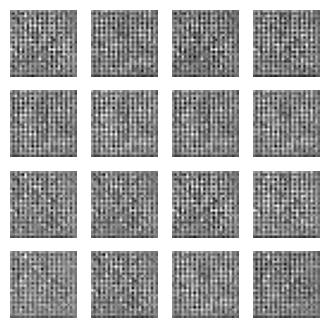

In [147]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Number of epochs for training
epochs = 50

# Dimensionality of the latent space
latent_dim = 2

# Number of examples to generate
num_examples_to_generate = 16

# Create a fixed random vector for generation
# This is useful for visualizing the progress of the model training
fixed_random_vector_for_generation = torch.randn(num_examples_to_generate, latent_dim)

# Instantiate the CVAE model
# model = CVAE(latent_dim=latent_dim)

# Example function to generate samples from the model
def generate_and_save_images(model, epoch, test_sample):
    model.eval()
    with torch.no_grad():
        mean, logvar = model.encode(test_sample)
        z = model.reparameterize(mean, logvar)
        predictions = model.decode(z)
        predictions = torch.sigmoid(predictions)  # Apply sigmoid to get pixel values in [0, 1]

    # Create a grid of images
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.size(0)-1):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].cpu().numpy().reshape(28, 28), cmap='gray')  # Assuming 28x28 images
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# for x in train_loader:  # Assuming you have a DataLoader 'data_loader' with your data
#         # Here, you would call the train_step function
#         loss = train_step(model, x[0])
#         #pass
# # Example usage
test_sample = next(iter(test_loader))[:num_examples_to_generate]

generate_and_save_images(model, 0, test_sample[0])


In [144]:
model = CVAE(latent_dim=latent_dim)
for epoch in range(2):
        for x in train_loader:  # Assuming you have a DataLoader 'data_loader' with your data
                # Here, you would call the train_step function
                loss = train_step(model, x[0])